# Brief
In this section I do data augmentation/synthesis to add more data record. I also explore the data after synthesize. 

# Project settings

In [1]:
import os
import sys

import pandas as pd

# sys.pwd()
os.chdir('../')
os.getcwd()

'/mnt/d/Assignment/Skillvull'

In [2]:
project_path= os.getcwd()
data_path= os.path.join(project_path,'data')
src_folder= os.path.join(project_path,'src','data')

# Do synthesize 
The HMASynthesizer is a powerful tool within the Synthetic Data Vault (SDV), designed to create synthetic data by learning from real data and generating high-quality synthetic samples. Why I choose this algorithm?
- The HMASynthesizer utilizes a hierarchical machine learning (ML) algorithm to learn from actual data and produce synthetic data.
- It focuses on modeling both individual tables and the connections between them.
- The algorithm leverages classical statistics to ensure accurate representation.
Suitability and Capabilities:
- The HMASynthesizer is well-suited for datasets with the following characteristics:
  - Around 5 tables in the dataset.
  - 1 level of depth, such as a parent table and its child table.


**Execute synthesize**

In [20]:
! python {src_folder+'/synthesize_data.py'}

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Load Dataset
dict_keys(['customers', 'customer_interactions', 'product_details', 'purchase_history'])
Data loaded
Create metadata
/home/elaina/miniconda3/envs/elaina/lib/python3.9/site-packages/sdv/metadata/multi_table.py:442: UserWarning: Could not automatically add relationships for all tables. The relationships in the dataset are disjointed. Tables ['customers', 'customer_interactions', 'product_details', 'purchase_history'] are not connected to any of the other tables.
  warnings.warn(warning_msg)
Metadata created
Validate metadata
Dataset validated
Preprocess Tables: 100%|██████████████████████████| 4/4 [00:00<00:00, 47.06it/s]

Learning relationships:
(1/3) Tables 'customers' and 'customer_interactions' ('customer_id'): 100%|█| 5/
(2/3) Tables 'customers' and 'purchase_history' ('customer_id'): 100%|█| 5/5 [00
(3/3) Tables 'product_details' and 'purchase_history' ('product_id'): 100%|█| 5/

Modeling Tables:

# Explore synthesized data


In [21]:
import pandas as pd
synthetic_data= pd.read_pickle(os.path.join(data_path,
                                            'interim',
                                            'synthetic',
                                            
                                            'synthetic_data.pickle'
                                            )
                               )

In [22]:
for key,val in synthetic_data.items():
    print(f'{key}:{str(val.shape[0])}')

customers:500
customer_interactions:500
purchase_history:998
product_details:500


In [28]:
customers= synthetic_data['customers'].copy()
customer_interactions= synthetic_data['customer_interactions'].copy()
purchase_history= synthetic_data['purchase_history'].copy()
product_details= synthetic_data['product_details'].copy()

## Electronic is most expensive product

<Axes: xlabel='category', ylabel='price'>

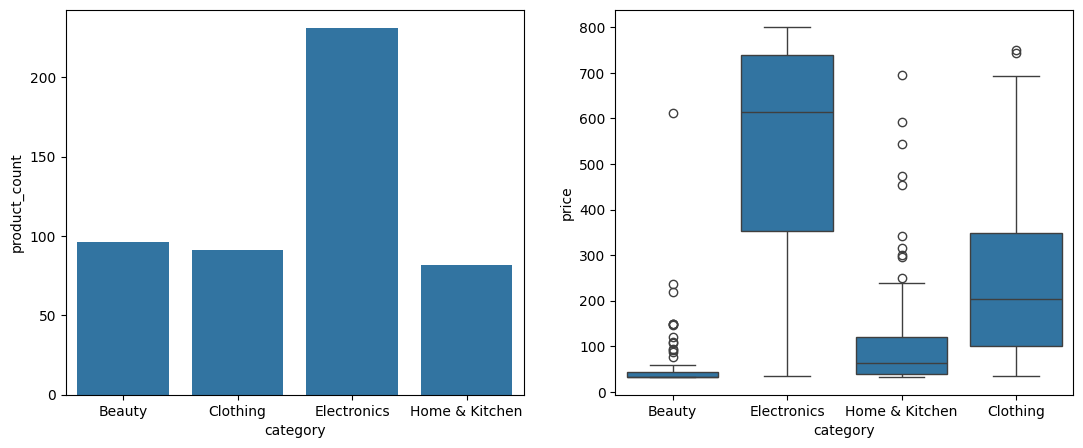

In [38]:
import matplotlib.pyplot as plt
import seaborn as sbn

product_count_by_category= product_details.groupby('category').count().reset_index().rename(columns={'price':'product_count'})
fig, ax= plt.subplots(nrows=1,
                      ncols=2,
                      figsize= (13,5)
                      )

sbn.barplot(x= 'category',
            y= 'product_count',
            data= product_count_by_category,
            ax= ax[0]
            )

sbn.boxplot(x= 'category',
            y= 'price',
            data= product_details,
            ax= ax[1]
            )

## Most customer visit fewer

In [114]:
purchase_history['order_num']= purchase_history.groupby(['customer_id'])

,customer_id,product_id,purchase_date,n_purchase
0,0,356,2023-01-05,1
1,0,117,2023-01-05,1
2,1,254,2023-01-03,1
3,1,26,2023-01-05,1
4,2,366,2023-01-04,1
...,...,...,...,...
993,497,134,2023-01-05,1
994,498,5,2023-01-04,1
995,498,392,2023-01-05,1
996,499,348,2023-01-05,1


In [52]:
customer_interactions.describe().loc[:, ['page_views','time_spent']]


,page_views,time_spent
count,500.000000,500.000000
mean,23.216000,119.460000
std,2.969002,20.537477
min,20.000000,90.000000
25%,21.000000,99.750000
50%,23.000000,119.000000
75%,25.000000,139.000000
max,30.000000,150.000000


<Axes: xlabel='page_views', ylabel='time_spent'>

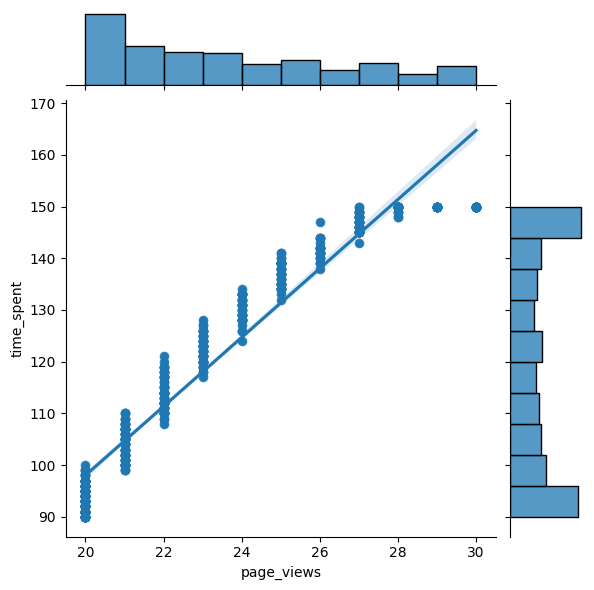

In [50]:
# fig,ax= plt.subplots()
axes=sbn.jointplot(x= 'page_views',
              y='time_spent',
              data= customer_interactions,
              # fig= fig
              )
sbn.regplot(x='page_views',
            y= 'time_spent',
            data= customer_interactions,
            # ax= axes
            )

## Electronics product tend to get better ratings

<Axes: xlabel='price', ylabel='ratings'>

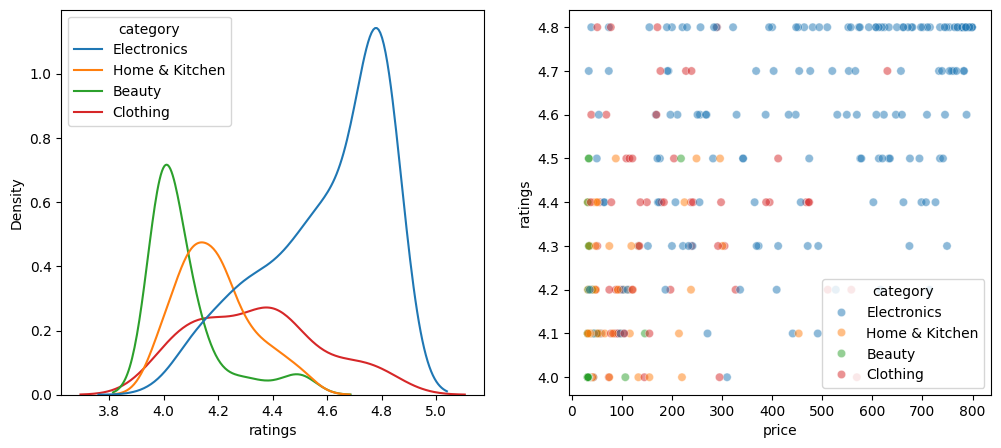

In [94]:
purchase_history_df = pd.merge(product_details,
                               purchase_history.groupby('product_id').agg(n_purchase=('customer_id',pd.Series.count)).reset_index(),
                               on='product_id'
                               )
fig,axes= plt.subplots(ncols=2,
                       figsize=(12,5)
                       )
a1= sbn.kdeplot(x='ratings',
                  data=purchase_history_df,
                  hue='category',
                ax= axes[0]
                 # fig=fig
                 # facet_kws={'gridspec_kws': {'ncols':1,'nrows':1}}
                  )
sbn.scatterplot(x= 'price',
            y= 'ratings',
            hue= 'category',
            data= purchase_history_df,
            ax= axes[1],
                alpha=0.5)

## How price, rating, and number of purchase correlated?

1. Higher rating correlates with higher price
2. For Beauty and clothing product, higher price means lower purchase. While that pattern not shown in Electronics and Home & Kitchen

In [102]:
corr=purchase_history_df.drop(columns='product_id').groupby('category').corr()
corr

price   ratings  n_purchase
category                                                 
Beauty         price       1.000000  0.360937   -0.124004
               ratings     0.360937  1.000000   -0.225442
               n_purchase -0.124004 -0.225442    1.000000
Clothing       price       1.000000  0.124387   -0.150554
               ratings     0.124387  1.000000   -0.208008
               n_purchase -0.150554 -0.208008    1.000000
Electronics    price       1.000000  0.428235   -0.107924
               ratings     0.428235  1.000000   -0.058304
               n_purchase -0.107924 -0.058304    1.000000
Home & Kitchen price       1.000000  0.174622   -0.002236
               ratings     0.174622  1.000000   -0.546379
               n_purchase -0.002236 -0.546379    1.000000

In [106]:
purchase_history['n_purchase']=1